In [30]:
!pip install openpyxl prophet xgboost

import pandas as pd
import numpy as np
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")

In [31]:
file_pre = "bursabeyazıtca2018-2020.xlsx"
file_post = "bursabeyazıtcad2020-2021.xlsx"

df_pre = pd.read_excel(file_pre, sheet_name="Sheet1", skiprows=1)
df_post = pd.read_excel(file_post, sheet_name="Sheet1", skiprows=1)

df_pre.columns = ["Tarih", "PM10", "SO2", "CO", "NO2", "NOX", "NO"]
df_post.columns = ["Tarih", "PM10", "SO2", "CO", "NO2", "NOX", "NO"]


In [32]:
def temizle(df):
    df["Tarih"] = pd.to_datetime(df["Tarih"])
    for col in df.columns:
        if col != "Tarih":
            df[col] = df[col].astype(str).str.replace("-", "", regex=False)
            df[col] = df[col].str.replace(",", ".", regex=False)
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

df_pre = temizle(df_pre)
df_post = temizle(df_post)

df = pd.concat([df_pre, df_post], ignore_index=True).sort_values("Tarih").reset_index(drop=True)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23qxj3y0/_dk90108.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23qxj3y0/e2a01ph8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21624', 'data', 'file=/tmp/tmp23qxj3y0/_dk90108.json', 'init=/tmp/tmp23qxj3y0/e2a01ph8.json', 'output', 'file=/tmp/tmp23qxj3y0/prophet_modelwfk_pbys/prophet_model-20250812081532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:15:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:15:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


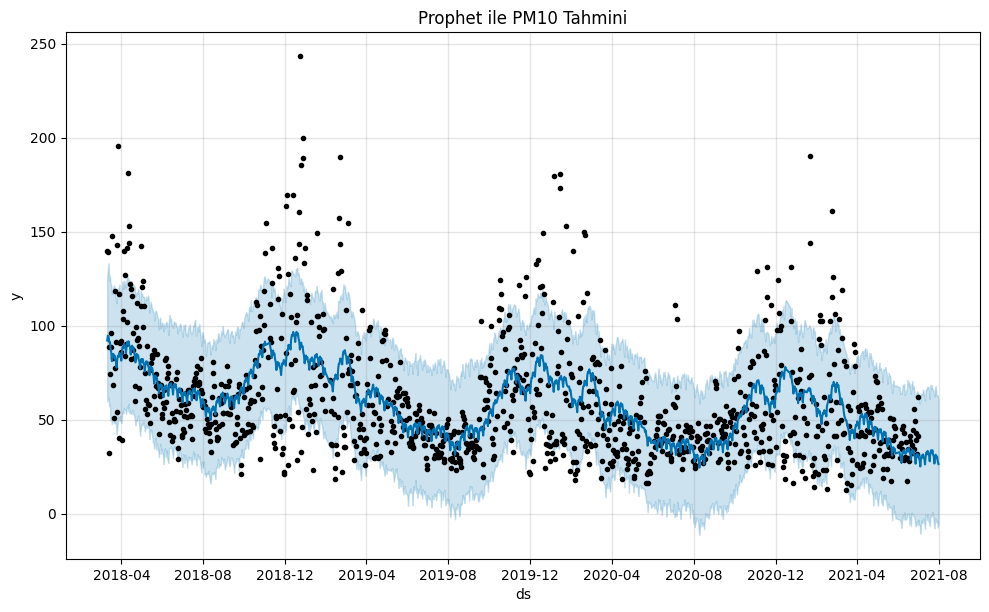

In [33]:
df_prophet = df[["Tarih", "PM10"]].rename(columns={"Tarih": "ds", "PM10": "y"}).dropna()

model_prophet = Prophet()
model_prophet.fit(df_prophet)

future = model_prophet.make_future_dataframe(periods=30)
forecast = model_prophet.predict(future)

model_prophet.plot(forecast)
plt.title("Prophet ile PM10 Tahmini")
plt.show()

In [34]:
from datetime import datetime

model = Prophet()
model.fit(df_prophet)

tahmin_sonu = pd.to_datetime("2025-04-24")

future = model.make_future_dataframe(periods=0)
son_tarih = future["ds"].max()

eksik_gun = (tahmin_sonu - son_tarih).days

future = model.make_future_dataframe(periods=eksik_gun)
forecast = model.predict(future)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23qxj3y0/ps2l2qk9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp23qxj3y0/cbmr0b_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64749', 'data', 'file=/tmp/tmp23qxj3y0/ps2l2qk9.json', 'init=/tmp/tmp23qxj3y0/cbmr0b_p.json', 'output', 'file=/tmp/tmp23qxj3y0/prophet_models23emube/prophet_model-20250812081533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:15:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:15:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


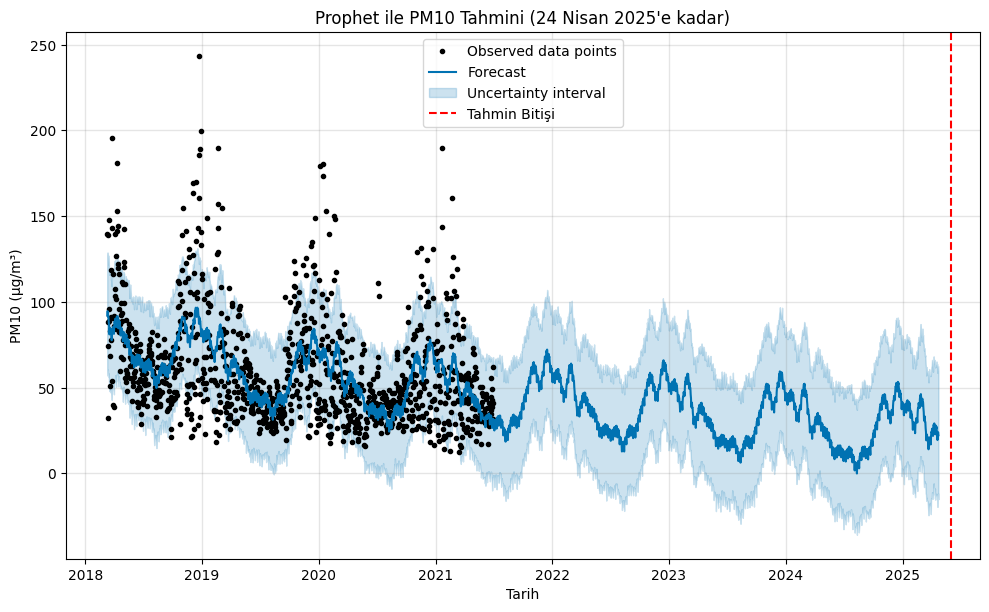

In [35]:
fig = model.plot(forecast)
plt.title("Prophet ile PM10 Tahmini (24 Nisan 2025'e kadar)")
plt.xlabel("Tarih")
plt.ylabel("PM10 (µg/m³)")
plt.axvline(x=pd.to_datetime("2025-06-1"), color="red", linestyle="--", label="Tahmin Bitişi")
plt.legend()
plt.show()



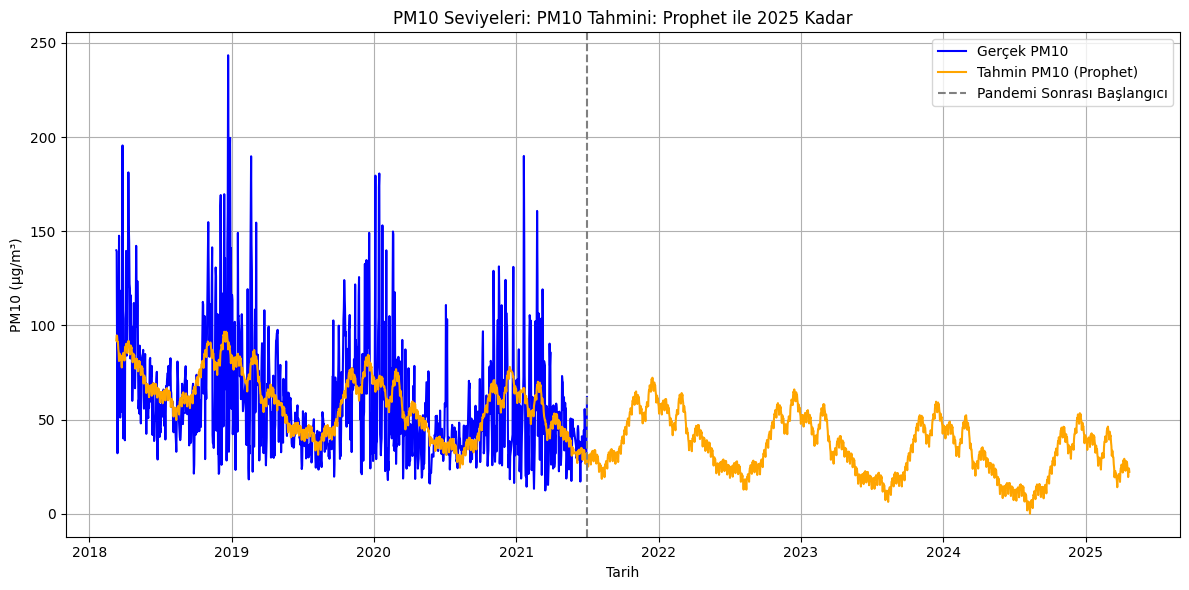

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(df_prophet["ds"], df_prophet["y"], label="Gerçek PM10", color="blue")

plt.plot(forecast["ds"], forecast["yhat"], label="Tahmin PM10 (Prophet)", color="orange")

plt.axvline(pd.to_datetime("2021-07-01"), color="gray", linestyle="--", label="Pandemi Sonrası Başlangıcı")

plt.title("PM10 Seviyeleri: PM10 Tahmini: Prophet ile 2025 Kadar")
plt.xlabel("Tarih")
plt.ylabel("PM10 (µg/m³)")

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [37]:
!pip install xgboost --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

df_pm10 = df[["Tarih", "PM10"]].dropna().copy()
df_pm10.columns = ["date", "pm10"]
df_pm10 = df_pm10.sort_values("date").reset_index(drop=True)

df_pm10["dayofweek"] = df_pm10["date"].dt.dayofweek
df_pm10["month"] = df_pm10["date"].dt.month
df_pm10["day"] = df_pm10["date"].dt.day

for lag in range(1, 8):
    df_pm10[f"lag_{lag}"] = df_pm10["pm10"].shift(lag)

df_pm10 = df_pm10.dropna().reset_index(drop=True)

pandemi_sonu = pd.to_datetime("2021-07-01")

train_df = df_pm10[df_pm10["date"] <= pandemi_sonu]
test_df = df_pm10[df_pm10["date"] > pandemi_sonu]

features = [col for col in train_df.columns if col.startswith("lag_") or col in ["dayofweek", "month", "day"]]
X_train = train_df[features]
y_train = train_df["pm10"]
X_test = test_df[features]
y_test = test_df["pm10"]
test_dates = test_df["date"]

model = XGBRegressor(n_estimators=50, max_depth=3, verbosity=0, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

results_df = pd.DataFrame({
    "date": test_dates,
    "actual_pm10": y_test.values,
    "predicted_pm10": y_pred
})

results_df.head()


,date,actual_pm10,predicted_pm10
1154,2021-07-01 00:00:56,62.05,39.93417


In [38]:
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

model = XGBRegressor(n_estimators=50, max_depth=3, verbosity=0, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

results_df = pd.DataFrame({
    "date": test_dates,
    "actual_pm10": y_test.values,
    "predicted_pm10": y_pred
})


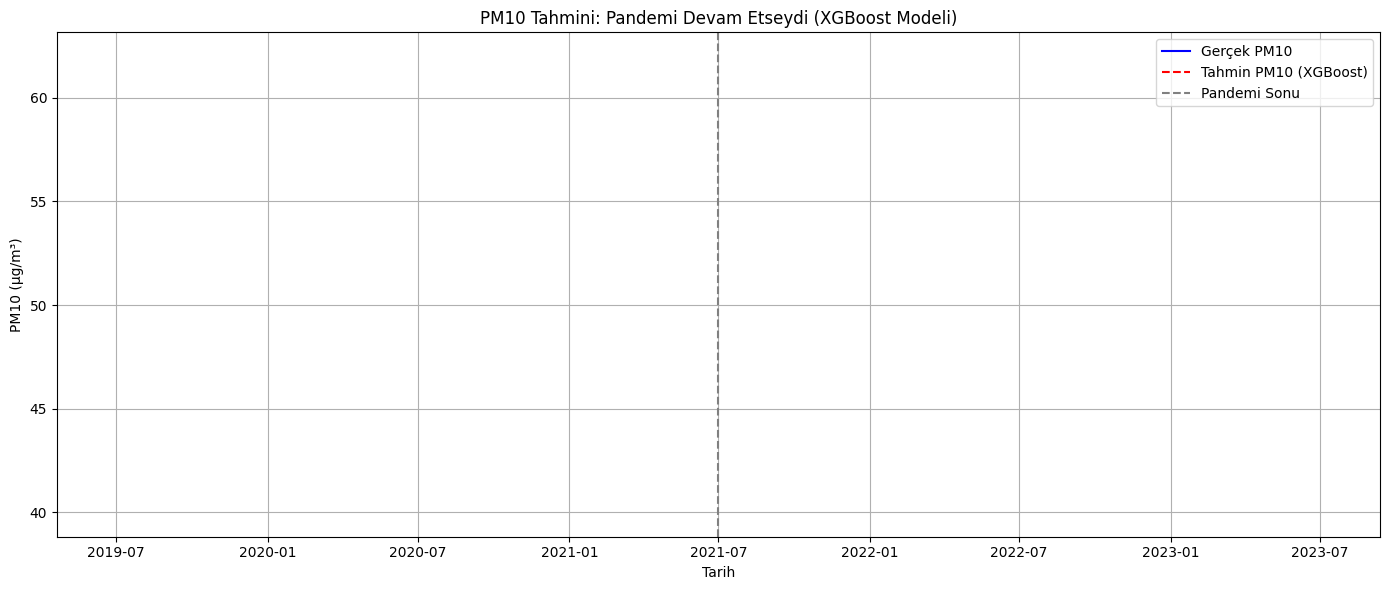

In [39]:
plt.figure(figsize=(14, 6))

plt.plot(results_df["date"], results_df["actual_pm10"], label="Gerçek PM10", color="blue")

plt.plot(results_df["date"], results_df["predicted_pm10"], label="Tahmin PM10 (XGBoost)", color="red", linestyle="--")

plt.axvline(pd.to_datetime("2021-07-01"), color="gray", linestyle="--", label="Pandemi Sonu")

plt.title("PM10 Tahmini: Pandemi Devam Etseydi (XGBoost Modeli)")
plt.xlabel("Tarih")
plt.ylabel("PM10 (µg/m³)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


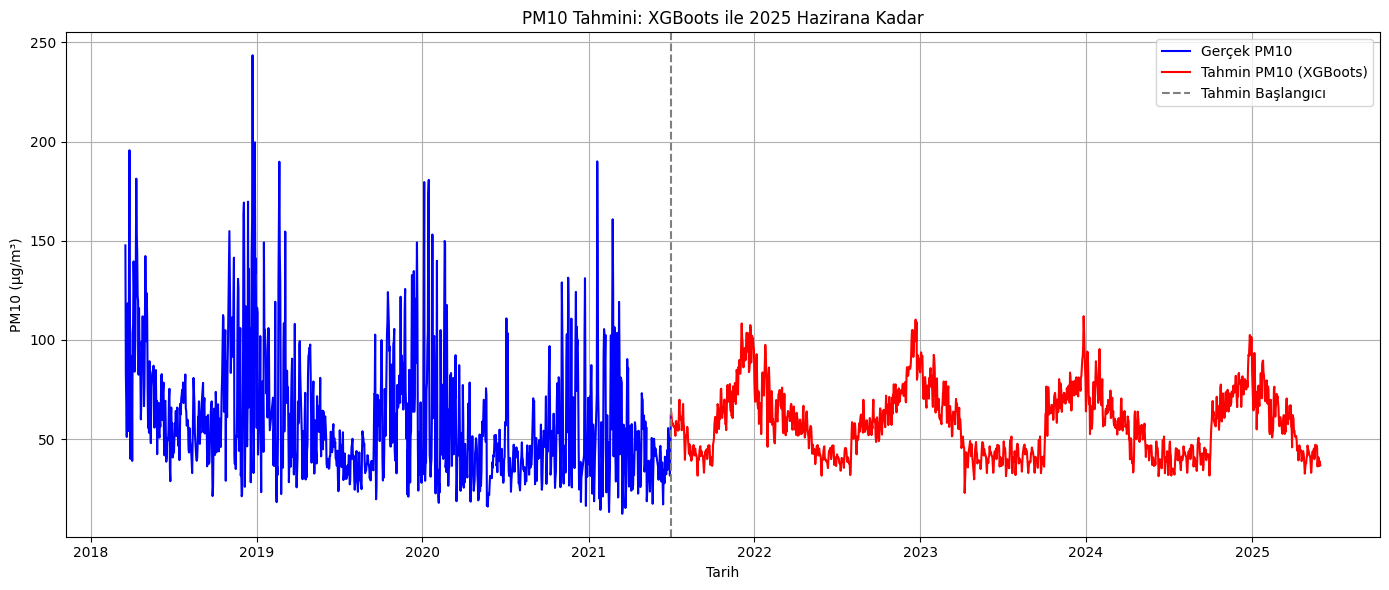

In [40]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

df_pm10 = df[["Tarih", "PM10"]].dropna().copy()
df_pm10.columns = ["date", "pm10"]
df_pm10 = df_pm10.sort_values("date").reset_index(drop=True)

df_pm10["dayofweek"] = df_pm10["date"].dt.dayofweek
df_pm10["month"] = df_pm10["date"].dt.month
df_pm10["day"] = df_pm10["date"].dt.day

for lag in range(1, 8):
    df_pm10[f"lag_{lag}"] = df_pm10["pm10"].shift(lag)

df_pm10 = df_pm10.dropna().reset_index(drop=True)

features = [col for col in df_pm10.columns if col.startswith("lag_") or col in ["dayofweek", "month", "day"]]
X_train = df_pm10[features]
y_train = df_pm10["pm10"]

model = XGBRegressor(n_estimators=100, max_depth=3, verbosity=0, random_state=42)
model.fit(X_train, y_train)

last_known = df_pm10.iloc[-1:].copy()
future_dates = pd.date_range(start=last_known["date"].values[0] + np.timedelta64(1, 'D'),
                             end="2025-06-01", freq="D")

future_predictions = []
history = df_pm10.copy()

for current_date in future_dates:
    row = {
        "date": current_date,
        "dayofweek": current_date.dayofweek,
        "month": current_date.month,
        "day": current_date.day
    }

    for lag in range(1, 8):
        row[f"lag_{lag}"] = history["pm10"].iloc[-lag]

    input_df = pd.DataFrame([row])
    prediction = model.predict(input_df[features])[0]
    row["pm10"] = prediction
    future_predictions.append(row)
    history = pd.concat([history, pd.DataFrame([row])], ignore_index=True)

forecast_df = pd.DataFrame(future_predictions)

plt.figure(figsize=(14, 6))
plt.plot(df_pm10["date"], df_pm10["pm10"], label="Gerçek PM10", color="blue")
plt.plot(forecast_df["date"], forecast_df["pm10"], label="Tahmin PM10 (XGBoots)", color="red",)
plt.axvline(x=pd.to_datetime("2021-07-01"), color="gray", linestyle="--", label="Tahmin Başlangıcı")
plt.title("PM10 Tahmini: XGBoots ile 2025 Hazirana Kadar")
plt.xlabel("Tarih")
plt.ylabel("PM10 (µg/m³)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [41]:
!pip install lightgbm openpyxl --quiet


In [42]:
import pandas as pd

df_pre = pd.read_excel("bursabeyazıtca2018-2020.xlsx", skiprows=1)
df_post = pd.read_excel("bursabeyazıtcad2020-2021.xlsx", skiprows=1)

df_pre.columns = df_post.columns = ["Tarih", "PM10", "SO2", "CO", "NO2", "NOX", "NO"]

df = pd.concat([df_pre, df_post], ignore_index=True)
df = df.sort_values("Tarih").reset_index(drop=True)

df["PM10"] = df["PM10"].astype(str).str.replace(",", ".").str.replace("-", "")
df["PM10"] = pd.to_numeric(df["PM10"], errors="coerce")

df = df[["Tarih", "PM10"]].dropna().copy()
df["Tarih"] = pd.to_datetime(df["Tarih"])


In [43]:
df["dayofweek"] = df["Tarih"].dt.dayofweek
df["month"] = df["Tarih"].dt.month
df["day"] = df["Tarih"].dt.day

for lag in range(1, 8):
    df[f"lag_{lag}"] = df["PM10"].shift(lag)

df = df.dropna().reset_index(drop=True)


In [44]:
import numpy as np

pandemi_sonu = pd.to_datetime("2021-07-01")

train_df = df[df["Tarih"] <= pandemi_sonu]
test_df = df[df["Tarih"] > pandemi_sonu]

features = [col for col in df.columns if col.startswith("lag_") or col in ["dayofweek", "month", "day"]]

X_train = train_df[features]
y_train = train_df["PM10"]
X_test = test_df[features]
y_test = test_df["PM10"]
test_dates = test_df["Tarih"].copy()


In [45]:
import lightgbm as lgb

model = lgb.LGBMRegressor(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 1154, number of used features: 10
[LightGBM] [Info] Start training from score 59.308536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [46]:
results_lgb = pd.DataFrame({
    "date": test_dates,
    "actual_pm10": y_test.values,
    "predicted_pm10": y_pred
})


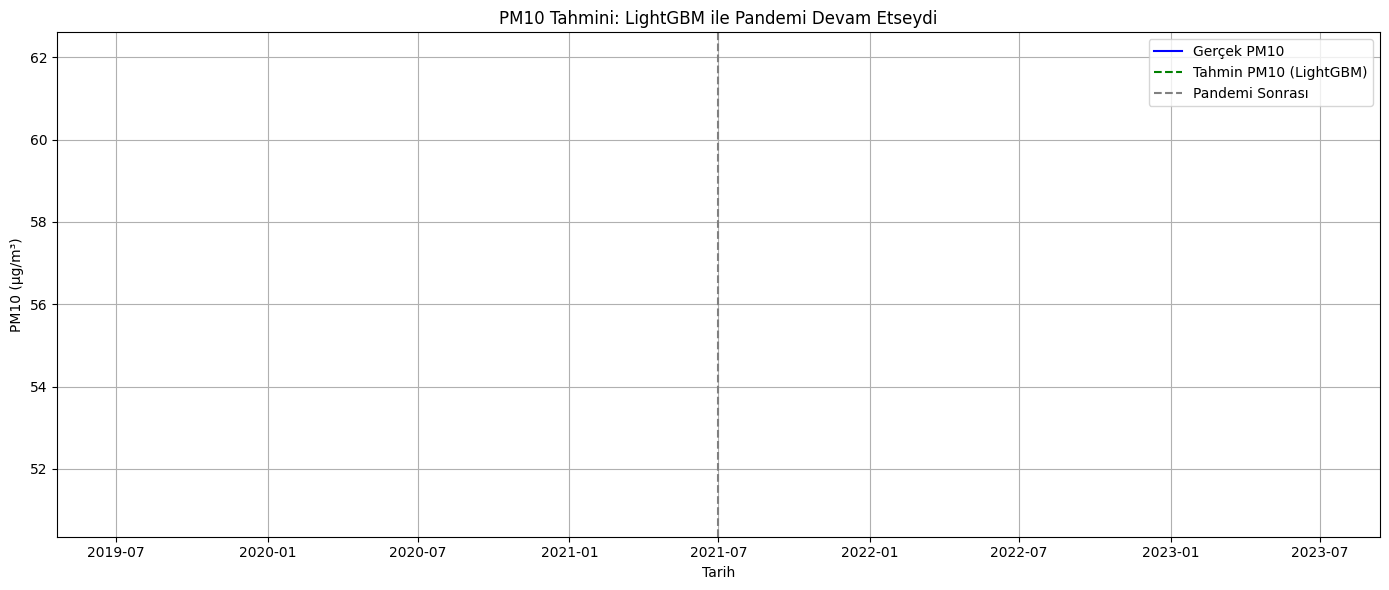

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(results_lgb["date"], results_lgb["actual_pm10"], label="Gerçek PM10", color="blue")
plt.plot(results_lgb["date"], results_lgb["predicted_pm10"], label="Tahmin PM10 (LightGBM)", color="green", linestyle="--")
plt.axvline(pd.to_datetime("2021-07-01"), color="gray", linestyle="--", label="Pandemi Sonrası")
plt.title("PM10 Tahmini: LightGBM ile Pandemi Devam Etseydi")
plt.xlabel("Tarih")
plt.ylabel("PM10 (µg/m³)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 1155, number of used features: 10
[LightGBM] [Info] Start training from score 59.310909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

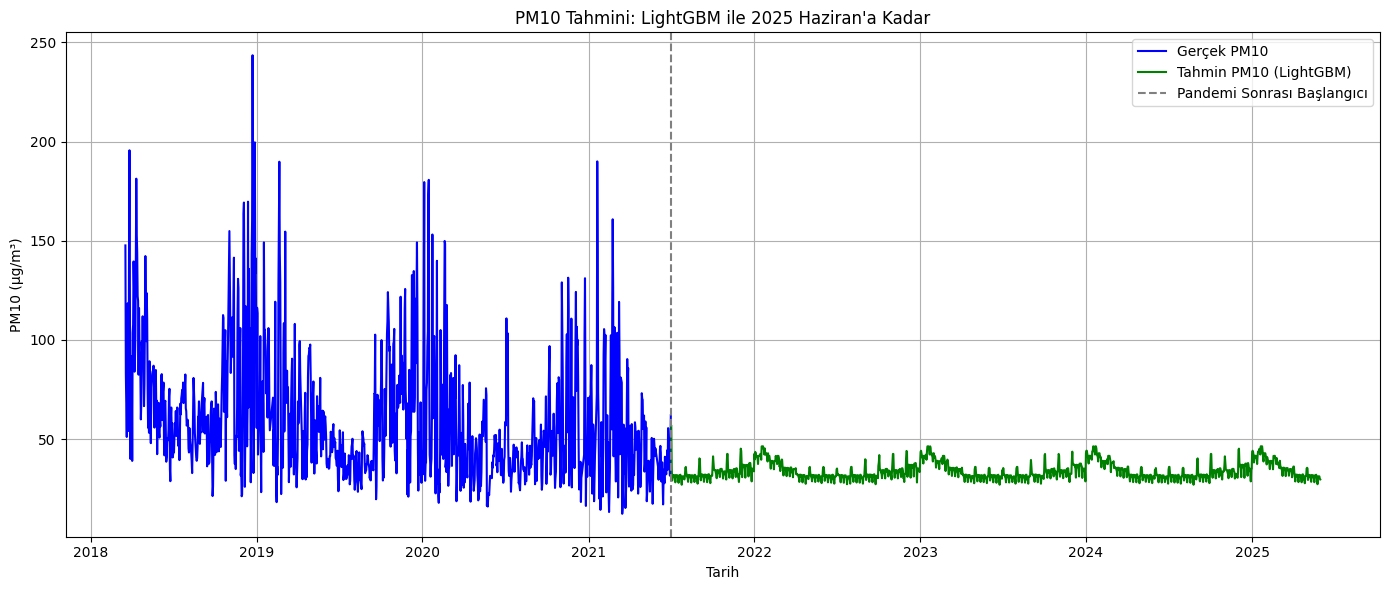

In [48]:
X_full = df[features]
y_full = df["PM10"]

model_full = lgb.LGBMRegressor(n_estimators=100, max_depth=5, random_state=42)
model_full.fit(X_full, y_full)

last_known_date = df["Tarih"].max()
forecast_end_date = pd.to_datetime("2025-06-01")

future_dates = pd.date_range(start=last_known_date + pd.Timedelta(days=1),
                             end=forecast_end_date, freq="D")

future_df = pd.DataFrame({"Tarih": future_dates})
future_df["dayofweek"] = future_df["Tarih"].dt.dayofweek
future_df["month"] = future_df["Tarih"].dt.month
future_df["day"] = future_df["Tarih"].dt.day

last_known_values = df.iloc[-1][["PM10"] + [f"lag_{i}" for i in range(1, 7)]].tolist()
future_lags_init = [last_known_values[0]] + last_known_values[:-1]

for i in range(1, 8):
  future_df.loc[0, f"lag_{i}"] = future_lags_init[i-1]


forecasted_values = []
history = df.copy()

for i, row in future_df.iterrows():
  input_data = row[features].values.reshape(1, -1)

  prediction = model_full.predict(input_data)[0]
  forecasted_values.append(prediction)

  new_row = row.copy()
  new_row["PM10"] = prediction
  history = pd.concat([history, pd.DataFrame([new_row])], ignore_index=True)

  if i < len(future_df) - 1:
    for lag in range(1, 8):
      future_df.loc[i+1, f"lag_{lag}"] = history["PM10"].iloc[-(lag)]


future_df["PM10"] = forecasted_values


combined_df = pd.concat([df[["Tarih", "PM10"]], future_df[["Tarih", "PM10"]]], ignore_index=True)

plt.figure(figsize=(14, 6))
plt.plot(df["Tarih"], df["PM10"], label="Gerçek PM10", color="blue")
plt.plot(future_df["Tarih"], future_df["PM10"], label="Tahmin PM10 (LightGBM)", color="green")
plt.axvline(pd.to_datetime("2021-07-01"), color="gray", linestyle="--", label="Pandemi Sonrası Başlangıcı")
plt.title("PM10 Tahmini: LightGBM ile 2025 Haziran'a Kadar")
plt.xlabel("Tarih")
plt.ylabel("PM10 (µg/m³)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

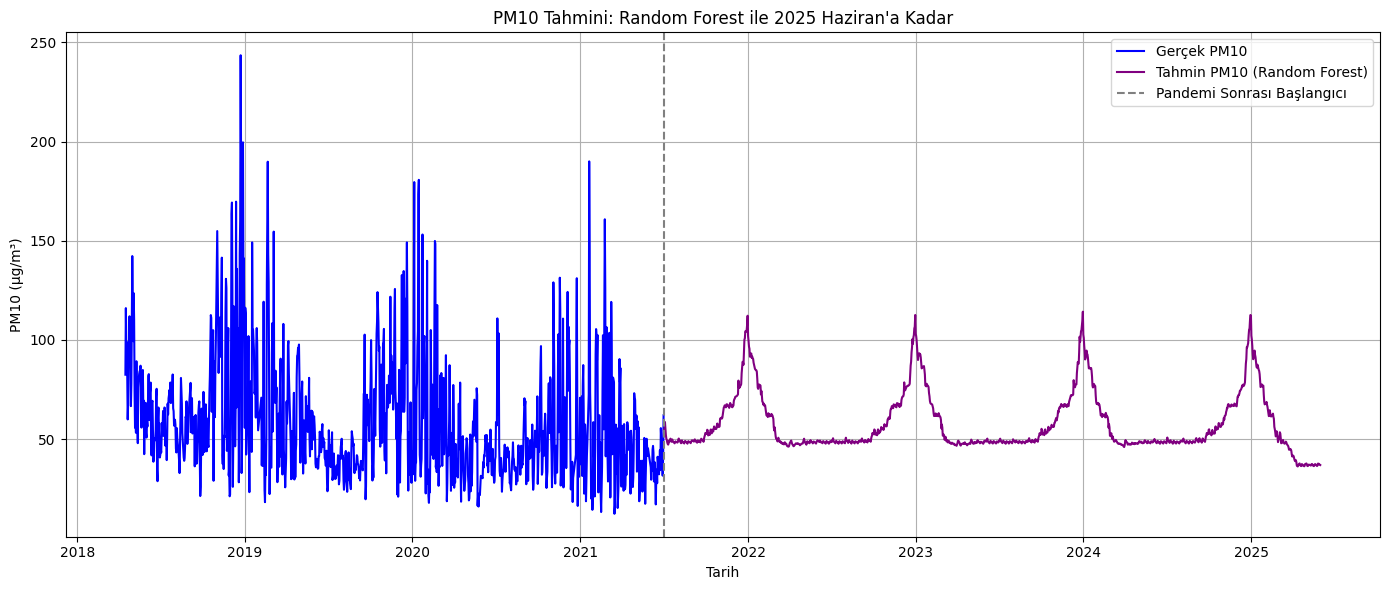

In [49]:
!pip install scikit-learn --quiet

from sklearn.ensemble import RandomForestRegressor

df_rf = df[["Tarih", "PM10"]].dropna().copy()
df_rf.columns = ["date", "pm10"]
df_rf = df_rf.sort_values("date").reset_index(drop=True)

df_rf["dayofweek"] = df_rf["date"].dt.dayofweek
df_rf["month"] = df_rf["date"].dt.month
df_rf["day"] = df_rf["date"].dt.day
df_rf["dayofyear"] = df_rf["date"].dt.dayofyear
df_rf["year"] = df_rf["date"].dt.year

for lag in range(1, 15):
    df_rf[f"lag_{lag}"] = df_rf["pm10"].shift(lag)

df_rf["rolling_mean_7"] = df_rf["pm10"].rolling(window=7).mean()
df_rf["rolling_mean_30"] = df_rf["pm10"].rolling(window=30).mean()

df_rf = df_rf.dropna().reset_index(drop=True)

features = [col for col in df_rf.columns if col not in ["date", "pm10"]]
X = df_rf[features]
y = df_rf["pm10"]

model_rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
model_rf.fit(X, y)

last_known_date_rf = df_rf["date"].max()
forecast_end_date_rf = pd.to_datetime("2025-06-01")

future_dates_rf = pd.date_range(start=last_known_date_rf + pd.Timedelta(days=1),
                               end=forecast_end_date_rf, freq="D")

future_df_rf = pd.DataFrame({"date": future_dates_rf})

future_df_rf["dayofweek"] = future_df_rf["date"].dt.dayofweek
future_df_rf["month"] = future_df_rf["date"].dt.month
future_df_rf["day"] = future_df_rf["date"].dt.day
future_df_rf["dayofyear"] = future_df_rf["date"].dt.dayofyear
future_df_rf["year"] = future_df_rf["date"].dt.year

history_rf = df_rf.copy()

forecasted_values_rf = []

for i, row in future_df_rf.iterrows():
    input_row = row.copy()
    for lag in range(1, 15):
        if len(history_rf) >= lag:
            input_row[f"lag_{lag}"] = history_rf["pm10"].iloc[-lag]
        else:
             input_row[f"lag_{lag}"] = history_rf["pm10"].iloc[0]

    if len(history_rf) >= 7:
        input_row["rolling_mean_7"] = history_rf["pm10"].iloc[-7:].mean()
    else:
         input_row["rolling_mean_7"] = history_rf["pm10"].mean()
    if len(history_rf) >= 30:
        input_row["rolling_mean_30"] = history_rf["pm10"].iloc[-30:].mean()
    else:
        input_row["rolling_mean_30"] = history_rf["pm10"].mean()

    input_data = input_row[features].values.reshape(1, -1)

    prediction = model_rf.predict(input_data)[0]
    forecasted_values_rf.append(prediction)

    new_row_history = row.copy()
    new_row_history["pm10"] = prediction
    history_rf = pd.concat([history_rf, pd.DataFrame([new_row_history])], ignore_index=True)


future_df_rf["pm10"] = forecasted_values_rf


combined_df_rf = pd.concat([df_rf[["date", "pm10"]], future_df_rf[["date", "pm10"]]], ignore_index=True)

plt.figure(figsize=(14, 6))
plt.plot(df_rf["date"], df_rf["pm10"], label="Gerçek PM10", color="blue")
plt.plot(future_df_rf["date"], future_df_rf["pm10"], label="Tahmin PM10 (Random Forest)", color="purple")
plt.axvline(pd.to_datetime("2021-07-01"), color="gray", linestyle="--", label="Pandemi Sonrası Başlangıcı")
plt.title("PM10 Tahmini: Random Forest ile 2025 Haziran'a Kadar")
plt.xlabel("Tarih")
plt.ylabel("PM10 (µg/m³)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()